In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import os
import numpy as np

from scipy import ndimage
from tensorflow.keras import regularizers
from scipy.io import loadmat

tf.keras.backend.set_floatx('float64')

In [ ]:
from urllib.request import urlretrieve
import zipfile
import os

def download_file(url, path):
    print("Downloading from %s" % url)
    zip_path = path + ".zip"
    urlretrieve(url, zip_path)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall("")
    os.remove(zip_path)    

In [ ]:
# Get data

import matplotlib.image as imageio

download_file("https://storage.googleapis.com/kagglesdsdata/competitions/3362/31148/test1.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1586455286&Signature=oS7Fn9tB7KyNGUL3AYhy%2Bu8v37g4wLyeNEl%2BG5f%2BjX2J4JprknIdxzrnn4dKICgT8XChG%2Bglp2NvV0ZbRSsDrUQ9EjRAnpJW%2BMUGYjtDChu3lJ5zcAae9fwYLmcJ1qmhQgNL4Wl5zx8FHR%2FWf9A%2BJaHwITBSlMcOsV%2F1ISwdnKgUTSGys8XlRrykqHm41lCA1t1%2FBo0OHLc68AEph%2FCFSvKC%2BmHkmytVLKw2j3nwyU2oAvoU91MB7Vvu52PsqzKEjVWkW%2Fn8dUonQApgCBvVQwVGfWXC5uAyAx%2BArUhDptW%2By7DKp7VpqjrjQevknjhxCVMZgRP0%2Fal1MSI8Hkw0KA%3D%3D&response-content-disposition=attachment%3B+filename%3Dtest1.zip", "test")
download_file("https://storage.googleapis.com/kagglesdsdata/competitions/3362/31148/train.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1586455311&Signature=J2i%2FQNaisVbuFdb48770XoZ2XvWPyUZwSi3LC5keEv5hBF8VR%2F2OQ3frq4VZdrNS0I0KXYjOlwEVbDIoZOMJbejPaRh4bDak9CpP%2BIwVwC5ZbfwUe5JyBR6HAjYomG67QEzWqJ9B4naPzIuPCuVVf4TGBxch0s8GqFmWuzqbnY3XSQp4FxZubdZQY4QuiTWXDAi%2BpWIxeBDK%2Fhr63KEr%2BsmhbYfwFTdVZMmdxbvjsFGc3x%2BK0I5ZbcJI00m%2FOQhYhTksgescjrEUs%2FcINVPdWdDaKgQbkFmiuki5SajMNg3BuC4CicjNpcCMaOrIUKOD9OU6kX7jS9brZXp0saol9w%3D%3D&response-content-disposition=attachment%3B+filename%3Dtrain.zip", "train")

os.mkdir("test")
for test_file in os.listdir("test1"):
    os.rename("test1/" + test_file, "test/" + test_file)
os.rmdir("test1")


train_dir = "train"

os.mkdir("train/train")
os.mkdir("train/val")

os.mkdir("train/train/dog")
os.mkdir("train/train/cat")

os.mkdir("train/val/dog")
os.mkdir("train/val/cat")

for file in os.listdir(train_dir):
    if "jpg" not in file:
        continue
    animal, im_id, _ = file.split('.')
    im_id = int(im_id)
    filename = train_dir + "/" + file
    if animal == "cat":
        if im_id <= val_size:
            target_dir = train_dir + "/val/cat/" + file
        else:
            target_dir = train_dir + "/train/cat/" + file
    else:
        if im_id <= val_size:
            target_dir = train_dir + "/val/dog/" + file
        else:
            target_dir = train_dir + "/train/dog/" + file

    os.rename(filename, target_dir)

In [2]:
train_dir = "train/train"
validation_dir = "train/val"
test_dir = "test"

IMG_HEIGHT = 150
IMG_WIDTH = 150

In [3]:
# Print statistics

train_cats_dir = os.path.join(train_dir, 'cat')  # directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dog')  # directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cat')  # directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dog')  # directory with our validation dog pictures

num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

num_test = len(os.listdir(test_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)
print("--")
print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)
print("Total test images:", num_test)

total training cat images: 11999
total training dog images: 11999
--
total validation cat images: 501
total validation dog images: 501
--
Total training images: 23998
Total validation images: 1002
Total test images: 12500


In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 32 

train_image_generator = ImageDataGenerator(rescale=1./255) 
val_image_generator = ImageDataGenerator(rescale=1./255)

train_data_gen = train_image_generator.flow_from_directory(
    batch_size=batch_size,
    directory=train_dir,
    shuffle=True,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary')

val_data_gen = val_image_generator.flow_from_directory(
    batch_size=batch_size,
    directory=validation_dir,
    shuffle=True,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary')

Found 23998 images belonging to 2 classes.
Found 1002 images belonging to 2 classes.


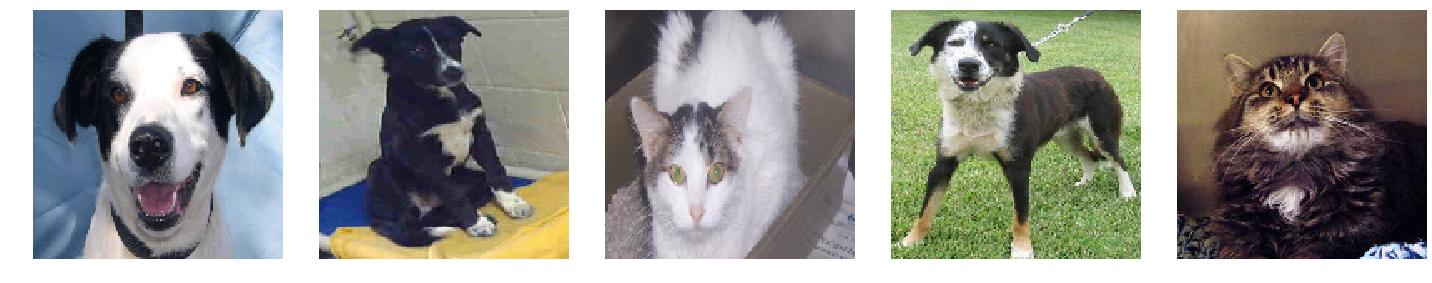

In [6]:
def plot_images(images):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
sample_training_images, _ = next(train_data_gen)
plot_images(sample_training_images[:5])

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D

model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 20736)             0

In [ ]:
history = model.fit_generator(
    train_data_gen,
    epochs=10,
    validation_data=val_data_gen
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 750 steps, validate for 32 steps
Epoch 1/10
 10/750 [..............................] - ETA: 1:04:20 - loss: 1.2712 - accuracy: 0.5375

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()